In [1]:
import tensorflow as tf

In [2]:
from konlpy.tag import Okt
okt = Okt()

In [5]:
with open('stopwords_kor.txt',mode= 'r',encoding= 'UTF-8') as f:
    stop = f.readlines()


In [8]:
from bs4 import BeautifulSoup
soup = BeautifulSoup()
stopwords = []
for i in stop:
    x = i.replace("\n",'')
    stopwords.append(x)

In [9]:
with open('ratings_train.txt',mode= 'r',encoding= 'UTF-8') as f:
    example = f.readlines()


In [10]:
def spacing_okt(wrongSentence):
    tagged = okt.pos(wrongSentence)
    corrected = ""
    for i in tagged:
        if i[1] in ('Josa', 'PreEomi', 'Eomi', 'Suffix', 'Punctuation'):
            corrected += i[0]
        else:
            corrected += " "+i[0]
    if corrected[0] == " ":
        corrected = corrected[1:]
    return corrected

print(spacing_okt("대한민국은민주공화국이다.대한민국의모든권력은국민으로부터나온다."))

대한민국은 민주공화국이다. 대한민국의 모든 권력은 국민으로부터 나온다.


In [15]:
def preprocess(example):
    from bs4 import BeautifulSoup
    sentences = []
    labels = []
    for items in example:
        sentence = items.replace(',', ' , ')
        sentence = sentence.replace('.', ' . ')
        sentence = sentence.replace('-', ' - ') 
        sentence = sentence.replace('/', ' / ')
        label = sentence.split('\t')[-1]
        labels.append(label) 
        sentences.append(sentence.split('\t')[1:-1])
    new_labels = []
    for i in labels:
        x = i.replace('\n', '')
        new_labels.append(x)
    new_sentence = []
    for i in sentences:
        if len(i) != 0:
            x = str(i).replace('[','')
            x = x.replace(']', '')
            new_sentence.append(x)
        else:
            new_sentence.append(' ')
    space_sentences = []
    for i in new_sentence:
        x = spacing_okt(i)
        space_sentences.append(x)
    new_labels = new_labels[1:]
    space_sentences = space_sentences[1:]
    labels = new_labels
    import string
    table = str.maketrans('', '',string.punctuation)
    sentences = []
    for i in space_sentences:
        sentence = i.replace(',', ' , ')
        sentence = sentence.replace('.', ' . ')
        sentence = sentence.replace('-', ' - ') 
        sentence = sentence.replace('/', ' / ')
        words = sentence.split()
        filtered_sentence = ""
        for word in words:
            word = word.translate(table)
            if word not in stopwords:
                filtered_sentence = filtered_sentence + word + " "
        sentences.append(filtered_sentence)
    return sentences, labels

In [16]:
sentences, labels = preprocess(example)

#### training, test 분리

In [39]:
training_sentences = sentences[0:130000]
test_sentences = sentences[130000:]
training_labels = labels[0:130000]
test_labels = labels[130000:]

In [41]:
import tensorflow as tf
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 20000, oov_token="<OOV>")
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

In [42]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
lengths = [len(x) for x in training_sentences]

{'whiskers': [<matplotlib.lines.Line2D at 0x225b357e408>,
 'caps': [<matplotlib.lines.Line2D at 0x225b357ed88>,
 'boxes': [<matplotlib.lines.Line2D at 0x225b3577d48>],
 'medians': [<matplotlib.lines.Line2D at 0x225b35823c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x225b3582b88>],
 'means': []}

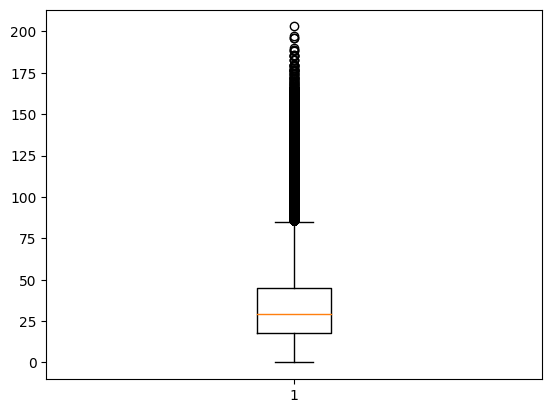

In [46]:
import matplotlib.pyplot as plt
# plt.hist(lengths)
plt.boxplot(lengths)
#max_length = 50으로 결정


In [53]:
#maxlength 50으로
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, maxlen = 50,padding='post',truncating='post')

In [54]:
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=50, padding='post', truncating='post')

In [55]:
training_padded.shape

(130000, 50)

In [56]:
class lstm_model(tf.keras.Model):
    def __init__(self):
        super(lstm_model,self).__init__()
        self.embedding_layer = tf.keras.Sequential([
            tf.keras.layers.Embedding(20000,50)                    
        ])
        self.lstm_layer = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50))
        ])
        self.out_layer = tf.keras.Sequential([
            tf.keras.layers.Dense(24),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(1,activation = 'sigmoid')
        ])
    def call(self, x):
        x = self.embedding_layer(x)
        x = self.lstm_layer(x)
        x = self.out_layer(x)
        return x


In [67]:
model = lstm_model()
model.build(input_shape = (1,50))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#### 콜백함수

In [64]:
check_point = tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', 
                                                 filepath='checkcheck.ckpt', 
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose = 1)

In [71]:
import numpy as np
training_padded = np.array(training_padded)
test_padded = np.array(test_padded)
training_labels = np.array(training_labels,dtype=int)
test_labels = np.array(test_labels,dtype=int)

In [73]:
history1 = model.fit(training_padded, training_labels, callbacks=[check_point], validation_data=(test_padded, test_labels), epochs=100,batch_size=128)

Epoch 1/100
1015/1016 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.5501
Epoch 1: val_loss improved from inf to 0.69068, saving model to checkcheck.ckpt
1016/1016 [==============================] - 54s 54ms/step - loss: 0.6920 - accuracy: 0.5502 - val_loss: 0.6907 - val_accuracy: 0.5834
Epoch 2/100
1016/1016 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.6243
Epoch 2: val_loss improved from 0.69068 to 0.67841, saving model to checkcheck.ckpt
1016/1016 [==============================] - 68s 67ms/step - loss: 0.6865 - accuracy: 0.6243 - val_loss: 0.6784 - val_accuracy: 0.6768
Epoch 3/100
1015/1016 [============================>.] - ETA: 0s - loss: 0.6492 - accuracy: 0.7155
Epoch 3: val_loss improved from 0.67841 to 0.61095, saving model to checkcheck.ckpt
1016/1016 [==============================] - 76s 75ms/step - loss: 0.6492 - accuracy: 0.7154 - val_loss: 0.6109 - val_accuracy: 0.7519
Epoch 4/100
1016/1016 [===========================

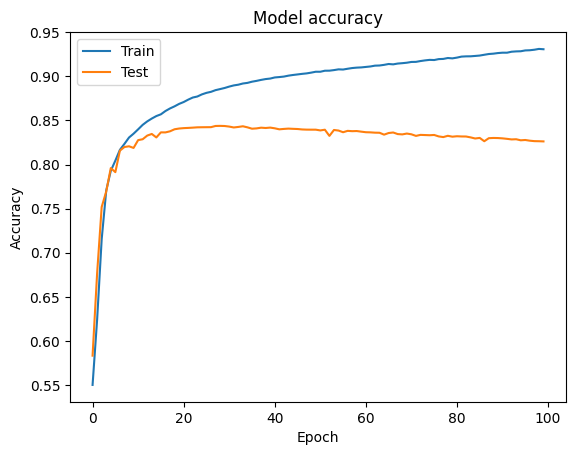

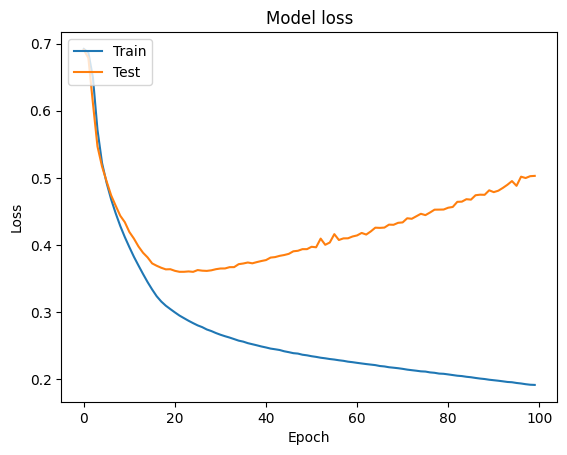

In [74]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 7 훈련 과정 시각화 (손실)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()